## Pretrained GAN

In [1]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path / 'images'
path_lr = path / 'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [5]:
from PIL import Image, ImageDraw, ImageFont

In [6]:
def crappify(fn, i):
    dest = path_lr / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w, h = img.size
    q = random.randint(10, 70)
    ImageDraw.Draw(img).text((random.randint(0, w//2), random.randint(0, h//2)), str(q), fill=(255, 255, 255))
    img.save(dest, quality=q)

Uncomment the first time you run this notebook.

In [11]:
# il = ImageItemList.from_folder(path_hr)
# parallel(crappify, il.items) # il.items returns array of images

For gradual resizing we can change the commented line here.

In [12]:
bs, size = 32, 128
# bs, size = 24, 160
# bs, size = 8, 256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [13]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [17]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr / x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [18]:
data_gen = get_data(bs, size)

In [19]:
# Sanity check
type(data_gen)

fastai.vision.data.ImageDataBunch

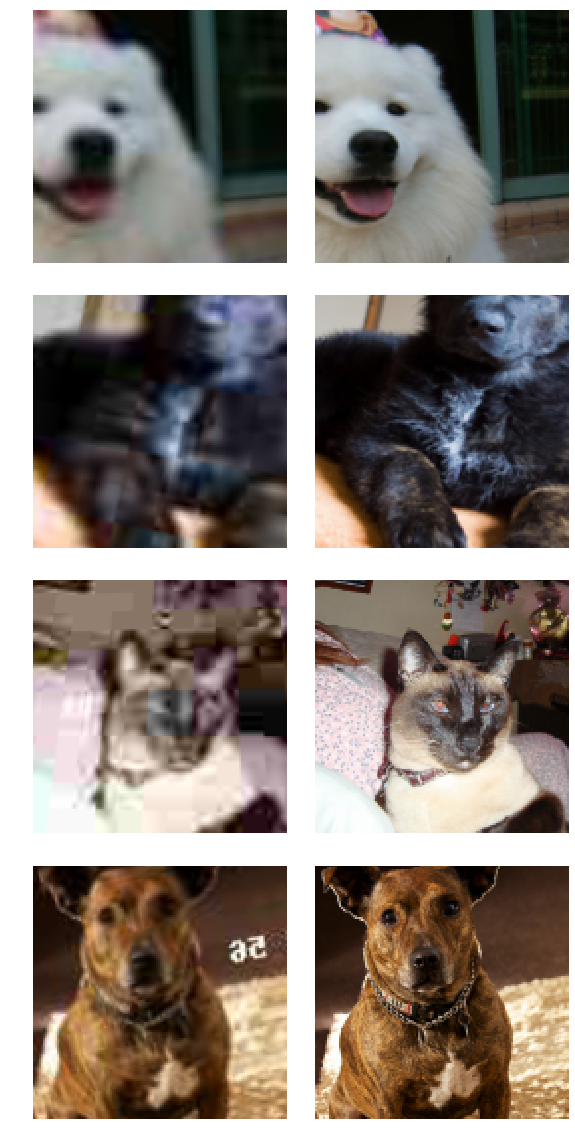

In [21]:
data_gen.show_batch(4)

In [22]:
wd = 1e-3

In [23]:
y_range = (-3., 3.)

In [24]:
loss_gen = MSELossFlat()

In [25]:
# create generator learner
def create_gen_learner():
     # blur argument is for PixelShuffle_ICNR
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [26]:
learn_gen = create_gen_learner()

In [27]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch     train_loss  valid_loss
1         0.063843    0.057545    
2         0.052317    0.049272    


In [28]:
learn_gen.unfreeze()

In [30]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch     train_loss  valid_loss
1         0.050844    0.048165    
2         0.048521    0.046062    
3         0.046637    0.045033    


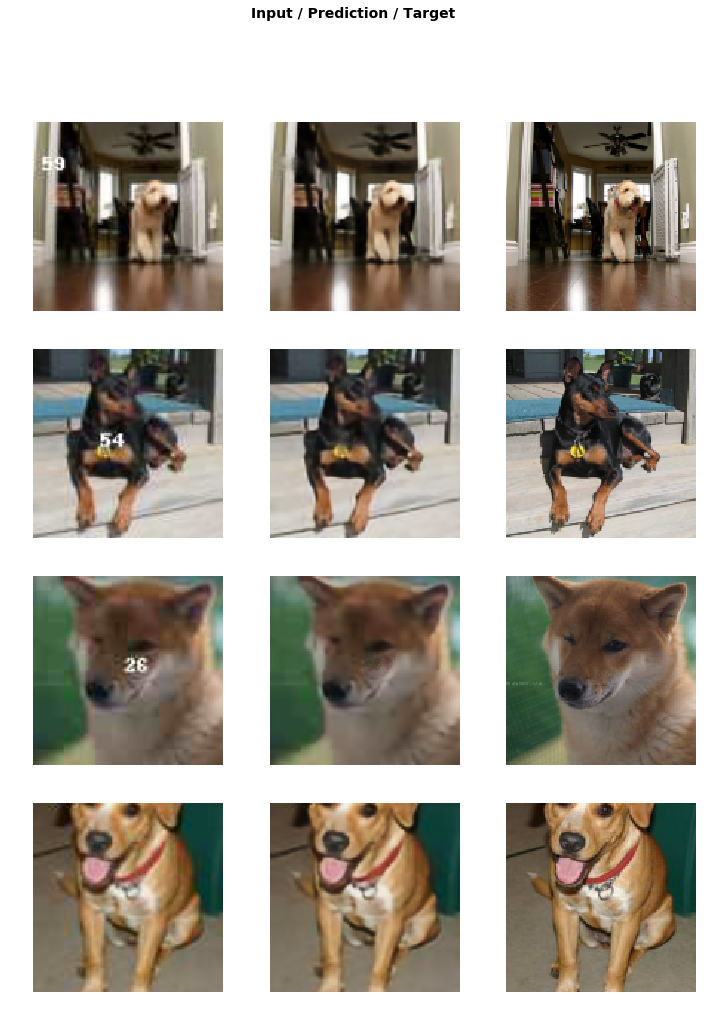

In [31]:
learn_gen.show_results(rows=4)

In [32]:
learn_gen.save('gen_pre2')

## Save generated images

In [33]:
learn_gen.load('gen_pre2')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 331, 500), Image (3, 500, 335), Image (3, 375, 500), Image (3, 500, 333), Image (3, 375, 500)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy
x: ImageImageList (6651 items)
[Image (3, 96, 145), Image (3, 143, 96), Image (3, 96, 128), Image (3, 144, 96), Image (3, 96, 128)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 500, 366), Image (3, 492, 500), Image (3, 375, 500), Image (3, 300, 190), Image (3, 375, 500)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy
x: ImageImageList (739 items)
[Image (3, 131, 96), Image (3, 96, 97), Image (3, 96, 128), Image (3, 151, 96), Image (3, 96, 128)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   

In [34]:
name_gen = 'image_gen'
path_gen = path / name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [36]:
path_gen.mkdir(exist_ok=True)

In [39]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen / names[i].name)
            i += 1

In [40]:
save_preds(data_gen.fix_dl)

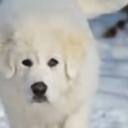

In [45]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [46]:
learn_gen=None
gc.collect()

22678

Pretrain the critic on crappy vs not crappy.

In [47]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
            .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [49]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

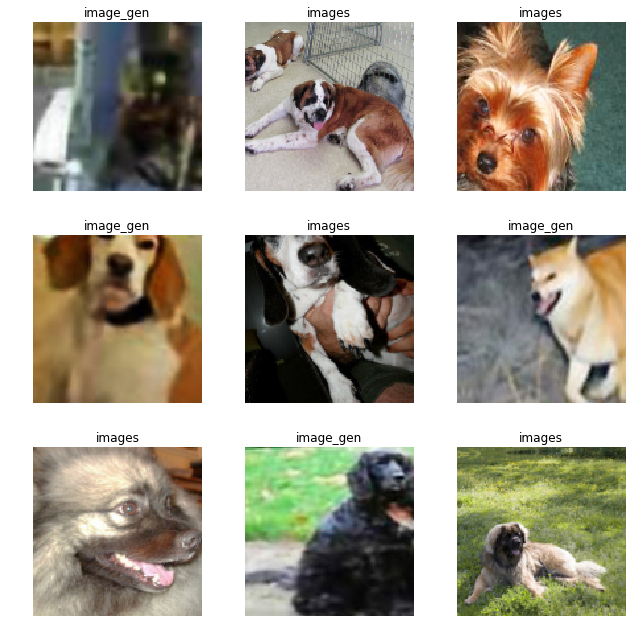

In [51]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [52]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [53]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [54]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [55]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch     train_loss  valid_loss  accuracy_thresh_expand
1         0.687101    0.687558    0.550000                
2         0.400085    0.717118    0.683219                
3         0.188067    0.608230    0.777493                
4         0.122945    0.313099    0.883989                
5         0.086369    0.131634    0.953989                
6         0.064002    0.098896    0.969914                


In [57]:
learn_critic.save('critic_pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [58]:
learn_gen = None
learn_critic = None
gc.collect()

15877

In [59]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [60]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic_pre2')

In [61]:
learn_gen = create_gen_learner().load('gen_pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator/critic to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [62]:
doc(AdaptiveGANSwitcher)
# Switcher (a LearnerCallback) that goes back to generator/critic when the loes goes below gen_thresh/crit_thresh.

In [63]:
doc(GANLearner)
# A Learner suitable for GANs.

In [64]:
doc(GANDiscriminativeLR)
# Callback that handles multiplying the learning rate by mult_lr for the critic.

In [65]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1., 50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0., 0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [66]:
lr = 1e-4

In [67]:
learn.fit(40, lr)

epoch     train_loss  gen_loss  disc_loss
1         2.125576    2.035303  4.047349   
2         2.038668    1.940441  3.742569   
3         1.998752    1.655455  3.683571   
4         1.935438    1.988385  3.592564   
5         2.016738    1.840756  3.617384   
6         1.895863    2.181625  3.580500   
7         1.938236    1.875703  3.570604   
8         1.919673    1.955053  3.559882   
9         1.995669    1.908432  3.565393   
10        1.995930    1.853988  3.602203   
11        2.025528    1.788676  3.594409   
12        2.030285    1.993515  3.600706   
13        2.013598    1.817824  3.617030   
14        2.037255    1.816738  3.615322   
15        1.930506    1.833512  3.546154   
16        1.996290    1.958869  3.592804   
17        1.999194    2.107492  3.626837   
18        1.933447    1.129894  3.584512   
19        2.001979    1.877815  3.591382   
20        1.909830    2.009139  3.564503   
21        1.987533    1.981500  3.559192   
22        1.995646    2.088564  3.

In [68]:
learn.save('gan_1c')

In [69]:
# change learner data_gen by assigning get_data(bs, sz)
learn.data = get_data(16, 192) # previously bs=32 and sz=128. increase img size, so half batch size.

In [70]:
learn.fit(10, lr/2) # progressive resizing technique in play here. halfing learning rate.

epoch     train_loss  gen_loss  disc_loss
1         2.573608    2.731844  4.739538   
2         2.738971    2.613524  4.903574   
3         2.666267    2.335060  4.768784   
4         2.650287    2.534996  4.781271   
5         2.546113    2.452332  4.709240   
6         2.559172    2.411619  4.747292   
7         2.520839    2.539139  4.705715   
8         2.507591    2.571561  4.638741   
9         2.617532    2.494489  4.770554   
10        2.475456    2.401739  4.664874   


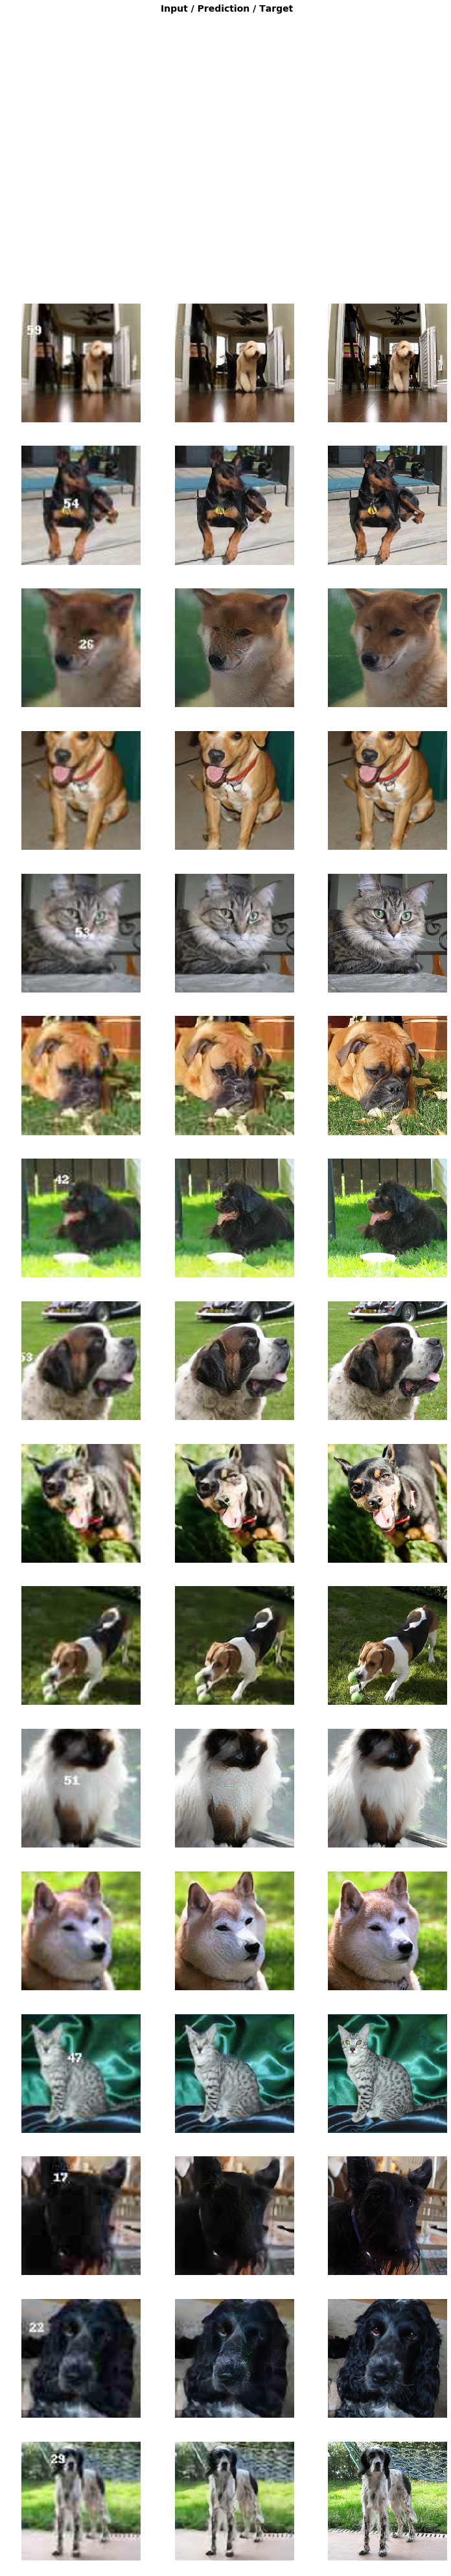

In [71]:
learn.show_results(rows=16)

In [72]:
learn.save('gan_1c_size_192')